In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
import math
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)
print(torch.__version__)
print(torchvision.__version__)

# device = torch.device("cpu")

cuda NVIDIA GeForce GTX 1080 Ti
1.12.1+cu116
0.13.1+cu116


In [3]:
from dataset import MusicSheetDataSet
import random

def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def crop(image, target, region, dataset):
    boxes = []
    labels = []
    for annotation in target:
        # print(annotation)
        orig_box = [x for x in annotation['a_bbox']]
        new_box = [
            max(orig_box[0], region[0]) - region[0],
            max(orig_box[1], region[1]) - region[1],
            min(orig_box[2], region[2]) - region[0],
            min(orig_box[3], region[3]) - region[1],
        ]

        if new_box[0] >= new_box[2] or new_box[1] >= new_box[3] or area(new_box) < area(orig_box) * 0.33:
            continue

        for cat_id in annotation['cat_id']:
            if (cat_id == None):
                continue

            category = dataset.get_category(cat_id)
            if (category['annotation_set'] != 'deepscores'):
                continue

            if (category['name'] in {'stem', 'ledgerLine'}):
                break
            # if (category['name'] in oneset):
            labels.append(int(cat_id))
            boxes.append(new_box)
    
    return (
        torch.tensor(image[region[1] : region[3], region[0] : region[2]]).div(255).unsqueeze(0),
        {
            'boxes': torch.tensor(boxes),
            'labels': torch.tensor(labels),
        }
    )

def transform(images, targets, dataset):
    image_res = []
    target_res = []
    for image, target in zip(images, targets):
        height, width = image.shape

        x = random.randrange(0, width // 2)
        y = random.randrange(0, height // 2)
        region = [x, y, x + width // 2, y + height // 2]

        i, t = crop(image, target, region, dataset)

        if t['boxes'].shape[0] == 0:
            region = [0, 0, width // 2, height // 2]
            i, t = crop(image, target, region, dataset)
        
        image_res.append(i)
        target_res.append(t)
    return image_res, target_res

dataset = MusicSheetDataSet("ds2_dense", "train")

In [4]:
import music

class MusicSymbolDetector:
    def __init__(self):
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
            pretrained=True,
            num_classes=137,
            min_size=1024,
            max_size=1024,
            box_detections_per_img=300
        )

        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.Adam(params)
        self.epoch = 0
        self.loss = 0
    
    def __call__(self, image):
        self.model.to(device)
        self.model.eval()
        # split image into 6 smaller image for accurate small object detection
        height, width = image.shape
        box_size = int(width * 0.55)

        x_starts = [0, width - box_size]
        y_starts = [0, (height - box_size) // 2, height - box_size]

        overlap_size_x = int(2 * box_size - width)
        overlap_size_y = int(3 * box_size - height) // 2

        results = []

        x_intersects: list[music.Label] = []
        y_intersects: list[music.Label] = []
        
        def check_x_intersects(x, label: music.Label):
            if label.x_min() <= x + overlap_size_x:
                for l in x_intersects:
                    if label.intersects_with(l) and label.name == l.name:
                        label.box = label.union(l).box
                        x_intersects.remove(l)
            # should be checked against the next x area
            if label.x_max() >= x + box_size - overlap_size_x:
                x_intersects_next.append(label)
                return True
            return False

        def check_y_intersect(y, label: music.Label):
            if label.y_min() <= y + overlap_size_y:
                for l in y_intersects:
                    if label.intersects_with(l) and label.name == l.name:
                        label.box = label.union(l).box
                        y_intersects.remove(l)
            # should be checked against the next y area
            if label.y_max() >= y + box_size - overlap_size_y:
                y_intersects_next.append(label)
                return True
            return False

        for y in y_starts:
            y_intersects_next = []
            for x in x_starts:
                x_intersects_next = []

                # inference on each sub image
                i = torch.tensor(image[y : y + box_size, x : x + box_size]).div(255).unsqueeze_(0).to(device)
                result = self.model([i])[0]

                result["boxes"][:, (0, 2)] += x
                result["boxes"][:, (1, 3)] += y

                for box, label in zip(result["boxes"].detach().cpu(), result["labels"].detach().cpu()):
                    label = music.Label(
                        dataset.get_category(label.item()),
                        box,
                    )

                    if check_x_intersects(x, label): continue
                    if check_y_intersect(y, label): continue
                    results.append(label)
                
                # all labels that didn't have intersect are added
                for label in x_intersects:
                    if check_y_intersect(y, label): continue
                    results.append(label)
                
                x_intersects = x_intersects_next
            
            # all labels at the end x edge
            for label in x_intersects:
                if check_y_intersect(y, label): continue
                results.append(label)

            x_intersects = []
            results.extend(y_intersects)

        # all labels at the end y edge
        results.extend(y_intersects)
        
        return results
    
    def save(self, path):
        torch.save({
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "epoch": self.epoch,
            "loss": self.loss,
        }, path)

    def load(self, path = None):
        if path == None:
            path = self
            self = MusicSymbolDetector()
        
        data = torch.load(path)
        self.model.load_state_dict(data['model'])
        self.optimizer.load_state_dict(data['optimizer'])
        current_epoch = data['epoch']
        
        print("loaded model at epoch: {}, loss: {}".format(current_epoch, data['loss']))

        # move optimizer to cuda
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

        return self
    
    def train(self, dataset : MusicSheetDataSet, epochs : int = 1, transform = None):
        self.model.to(device)
        self.model.train()
        torch.cuda.empty_cache()

        data_count = len(dataset)

        for _ in range(epochs):
            all_losses = 0
            all_losses_dict = {}

            dataloader = DataLoader(
                dataset,
                collate_fn=lambda x : zip(*x),
                shuffle = True
            )

            for images, targets in tqdm(dataloader):
                if transform != None:
                    images, targets = transform(images, targets, dataset)
                
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                self.optimizer.zero_grad(set_to_none=True)

                loss_dict: dict[str, torch.Tensor] = self.model(images, targets) # the model computes the loss automatically if we pass in targets

                losses: torch.Tensor = sum(loss for loss in loss_dict.values())

                loss_value = losses.item()
                all_losses += loss_value
                
                for k, v in loss_dict.items():
                    if k not in all_losses_dict:
                        all_losses_dict[k] = 0
                    all_losses_dict[k] += v
                
                if not math.isfinite(loss_value):
                    print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
                    print(loss_dict)
                    sys.exit(1)
                
                losses.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
                self.optimizer.step()
            
            self.epoch += 1
            self.loss = all_losses / data_count
            print("Epoch {:>3}, lr: {:.6f}, loss: {:.6f}, {}".format(
                self.epoch,
                self.optimizer.param_groups[0]['lr'], 
                self.loss,
                ', '.join("{}: {:.6f}".format(k, v / data_count) for k, v in all_losses_dict.items()),
            ))

            self.save(f"model/{self.epoch}")


In [5]:
# detector = MusicSymbolDetector()
# detector.train(dataset, 50, transform)

100%|██████████| 1362/1362 [06:05<00:00,  3.73it/s]


Epoch   1, lr: 0.001000, loss: 1.621204, loss_classifier: 0.515383, loss_box_reg: 0.433956, loss_objectness: 0.163595, loss_rpn_box_reg: 0.508269


100%|██████████| 1362/1362 [05:59<00:00,  3.79it/s]


Epoch   2, lr: 0.001000, loss: 1.024715, loss_classifier: 0.244193, loss_box_reg: 0.259149, loss_objectness: 0.115200, loss_rpn_box_reg: 0.406173


100%|██████████| 1362/1362 [05:59<00:00,  3.79it/s]


Epoch   3, lr: 0.001000, loss: 0.819167, loss_classifier: 0.164163, loss_box_reg: 0.202000, loss_objectness: 0.087950, loss_rpn_box_reg: 0.365053


100%|██████████| 1362/1362 [05:58<00:00,  3.80it/s]


Epoch   4, lr: 0.001000, loss: 0.737240, loss_classifier: 0.135424, loss_box_reg: 0.180051, loss_objectness: 0.078021, loss_rpn_box_reg: 0.343745


100%|██████████| 1362/1362 [05:55<00:00,  3.84it/s]


Epoch   5, lr: 0.001000, loss: 0.685685, loss_classifier: 0.122057, loss_box_reg: 0.167328, loss_objectness: 0.072595, loss_rpn_box_reg: 0.323704


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch   6, lr: 0.001000, loss: 0.613555, loss_classifier: 0.109698, loss_box_reg: 0.155050, loss_objectness: 0.060485, loss_rpn_box_reg: 0.288323


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch   7, lr: 0.001000, loss: 0.571527, loss_classifier: 0.100342, loss_box_reg: 0.146167, loss_objectness: 0.056102, loss_rpn_box_reg: 0.268916


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch   8, lr: 0.001000, loss: 0.539196, loss_classifier: 0.090510, loss_box_reg: 0.135068, loss_objectness: 0.057157, loss_rpn_box_reg: 0.256462


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch   9, lr: 0.001000, loss: 0.506877, loss_classifier: 0.085407, loss_box_reg: 0.129356, loss_objectness: 0.051294, loss_rpn_box_reg: 0.240819


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  10, lr: 0.001000, loss: 0.480621, loss_classifier: 0.079811, loss_box_reg: 0.124284, loss_objectness: 0.051898, loss_rpn_box_reg: 0.224628


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch  11, lr: 0.001000, loss: 0.469555, loss_classifier: 0.079472, loss_box_reg: 0.119989, loss_objectness: 0.048009, loss_rpn_box_reg: 0.222084


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  12, lr: 0.001000, loss: 0.452740, loss_classifier: 0.072627, loss_box_reg: 0.116362, loss_objectness: 0.047447, loss_rpn_box_reg: 0.216305


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch  13, lr: 0.001000, loss: 0.437368, loss_classifier: 0.070166, loss_box_reg: 0.116762, loss_objectness: 0.043205, loss_rpn_box_reg: 0.207236


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  14, lr: 0.001000, loss: 0.426209, loss_classifier: 0.067067, loss_box_reg: 0.111783, loss_objectness: 0.045705, loss_rpn_box_reg: 0.201654


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  15, lr: 0.001000, loss: 0.415663, loss_classifier: 0.067079, loss_box_reg: 0.109582, loss_objectness: 0.042558, loss_rpn_box_reg: 0.196445


100%|██████████| 1362/1362 [05:45<00:00,  3.94it/s]


Epoch  16, lr: 0.001000, loss: 0.402636, loss_classifier: 0.062027, loss_box_reg: 0.104530, loss_objectness: 0.041787, loss_rpn_box_reg: 0.194291


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  17, lr: 0.001000, loss: 0.387205, loss_classifier: 0.059891, loss_box_reg: 0.102014, loss_objectness: 0.038540, loss_rpn_box_reg: 0.186760


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch  18, lr: 0.001000, loss: 0.384656, loss_classifier: 0.058636, loss_box_reg: 0.101505, loss_objectness: 0.040396, loss_rpn_box_reg: 0.184118


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch  19, lr: 0.001000, loss: 0.377920, loss_classifier: 0.058008, loss_box_reg: 0.100046, loss_objectness: 0.038413, loss_rpn_box_reg: 0.181452


100%|██████████| 1362/1362 [05:38<00:00,  4.02it/s]


Epoch  20, lr: 0.001000, loss: 0.375657, loss_classifier: 0.056361, loss_box_reg: 0.097847, loss_objectness: 0.040651, loss_rpn_box_reg: 0.180798


100%|██████████| 1362/1362 [05:37<00:00,  4.04it/s]


Epoch  21, lr: 0.001000, loss: 0.362491, loss_classifier: 0.055866, loss_box_reg: 0.097215, loss_objectness: 0.037626, loss_rpn_box_reg: 0.171784


100%|██████████| 1362/1362 [05:46<00:00,  3.94it/s]


Epoch  22, lr: 0.001000, loss: 0.353055, loss_classifier: 0.055319, loss_box_reg: 0.095638, loss_objectness: 0.034978, loss_rpn_box_reg: 0.167119


100%|██████████| 1362/1362 [05:45<00:00,  3.95it/s]


Epoch  23, lr: 0.001000, loss: 0.341048, loss_classifier: 0.053063, loss_box_reg: 0.093814, loss_objectness: 0.032346, loss_rpn_box_reg: 0.161825


100%|██████████| 1362/1362 [05:35<00:00,  4.06it/s]


Epoch  24, lr: 0.001000, loss: 0.342870, loss_classifier: 0.052049, loss_box_reg: 0.093378, loss_objectness: 0.033011, loss_rpn_box_reg: 0.164433


100%|██████████| 1362/1362 [05:35<00:00,  4.06it/s]


Epoch  25, lr: 0.001000, loss: 0.336404, loss_classifier: 0.051486, loss_box_reg: 0.092641, loss_objectness: 0.034440, loss_rpn_box_reg: 0.157837


100%|██████████| 1362/1362 [05:34<00:00,  4.07it/s]


Epoch  26, lr: 0.001000, loss: 0.335251, loss_classifier: 0.049961, loss_box_reg: 0.091221, loss_objectness: 0.032958, loss_rpn_box_reg: 0.161111


100%|██████████| 1362/1362 [05:34<00:00,  4.07it/s]


Epoch  27, lr: 0.001000, loss: 0.328095, loss_classifier: 0.051578, loss_box_reg: 0.088522, loss_objectness: 0.033077, loss_rpn_box_reg: 0.154918


100%|██████████| 1362/1362 [05:42<00:00,  3.98it/s]


Epoch  28, lr: 0.001000, loss: 0.323611, loss_classifier: 0.048465, loss_box_reg: 0.087404, loss_objectness: 0.031993, loss_rpn_box_reg: 0.155749


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  29, lr: 0.001000, loss: 0.324851, loss_classifier: 0.048680, loss_box_reg: 0.088061, loss_objectness: 0.032563, loss_rpn_box_reg: 0.155546


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  30, lr: 0.001000, loss: 0.312373, loss_classifier: 0.044997, loss_box_reg: 0.086739, loss_objectness: 0.029604, loss_rpn_box_reg: 0.151034


100%|██████████| 1362/1362 [05:44<00:00,  3.95it/s]


Epoch  31, lr: 0.001000, loss: 0.312123, loss_classifier: 0.045868, loss_box_reg: 0.084014, loss_objectness: 0.031803, loss_rpn_box_reg: 0.150438


100%|██████████| 1362/1362 [05:44<00:00,  3.95it/s]


Epoch  32, lr: 0.001000, loss: 0.305555, loss_classifier: 0.045345, loss_box_reg: 0.083847, loss_objectness: 0.028783, loss_rpn_box_reg: 0.147580


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  33, lr: 0.001000, loss: 0.305086, loss_classifier: 0.043794, loss_box_reg: 0.083478, loss_objectness: 0.030361, loss_rpn_box_reg: 0.147453


100%|██████████| 1362/1362 [05:43<00:00,  3.97it/s]


Epoch  34, lr: 0.001000, loss: 0.305119, loss_classifier: 0.045072, loss_box_reg: 0.083029, loss_objectness: 0.029131, loss_rpn_box_reg: 0.147887


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  35, lr: 0.001000, loss: 0.302196, loss_classifier: 0.044761, loss_box_reg: 0.083537, loss_objectness: 0.029157, loss_rpn_box_reg: 0.144741


100%|██████████| 1362/1362 [05:45<00:00,  3.94it/s]


Epoch  36, lr: 0.001000, loss: 0.293683, loss_classifier: 0.045380, loss_box_reg: 0.081817, loss_objectness: 0.027724, loss_rpn_box_reg: 0.138763


100%|██████████| 1362/1362 [05:45<00:00,  3.95it/s]


Epoch  37, lr: 0.001000, loss: 0.292348, loss_classifier: 0.044763, loss_box_reg: 0.080545, loss_objectness: 0.027893, loss_rpn_box_reg: 0.139147


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  38, lr: 0.001000, loss: 0.291714, loss_classifier: 0.043525, loss_box_reg: 0.080594, loss_objectness: 0.027785, loss_rpn_box_reg: 0.139810


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  39, lr: 0.001000, loss: 0.289005, loss_classifier: 0.042024, loss_box_reg: 0.079639, loss_objectness: 0.027971, loss_rpn_box_reg: 0.139370


100%|██████████| 1362/1362 [05:44<00:00,  3.95it/s]


Epoch  40, lr: 0.001000, loss: 0.286011, loss_classifier: 0.040400, loss_box_reg: 0.080249, loss_objectness: 0.026503, loss_rpn_box_reg: 0.138858


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  41, lr: 0.001000, loss: 0.284172, loss_classifier: 0.040412, loss_box_reg: 0.079164, loss_objectness: 0.027172, loss_rpn_box_reg: 0.137424


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  42, lr: 0.001000, loss: 0.281532, loss_classifier: 0.040682, loss_box_reg: 0.078064, loss_objectness: 0.026376, loss_rpn_box_reg: 0.136410


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  43, lr: 0.001000, loss: 0.281440, loss_classifier: 0.041453, loss_box_reg: 0.077616, loss_objectness: 0.026817, loss_rpn_box_reg: 0.135554


100%|██████████| 1362/1362 [05:45<00:00,  3.94it/s]


Epoch  44, lr: 0.001000, loss: 0.279434, loss_classifier: 0.041759, loss_box_reg: 0.077200, loss_objectness: 0.026095, loss_rpn_box_reg: 0.134380


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  45, lr: 0.001000, loss: 0.274796, loss_classifier: 0.041519, loss_box_reg: 0.076678, loss_objectness: 0.024016, loss_rpn_box_reg: 0.132582


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  46, lr: 0.001000, loss: 0.275879, loss_classifier: 0.041842, loss_box_reg: 0.076932, loss_objectness: 0.025141, loss_rpn_box_reg: 0.131963


100%|██████████| 1362/1362 [05:44<00:00,  3.96it/s]


Epoch  47, lr: 0.001000, loss: 0.273275, loss_classifier: 0.041201, loss_box_reg: 0.076404, loss_objectness: 0.026600, loss_rpn_box_reg: 0.129070


100%|██████████| 1362/1362 [05:43<00:00,  3.96it/s]


Epoch  48, lr: 0.001000, loss: 0.259699, loss_classifier: 0.036092, loss_box_reg: 0.072667, loss_objectness: 0.024647, loss_rpn_box_reg: 0.126293


100%|██████████| 1362/1362 [05:44<00:00,  3.95it/s]


Epoch  49, lr: 0.001000, loss: 0.267926, loss_classifier: 0.037231, loss_box_reg: 0.074314, loss_objectness: 0.025478, loss_rpn_box_reg: 0.130903


100%|██████████| 1362/1362 [05:44<00:00,  3.95it/s]


Epoch  50, lr: 0.001000, loss: 0.266888, loss_classifier: 0.038522, loss_box_reg: 0.076268, loss_objectness: 0.023880, loss_rpn_box_reg: 0.128218


In [6]:
detector = MusicSymbolDetector.load("model/50")

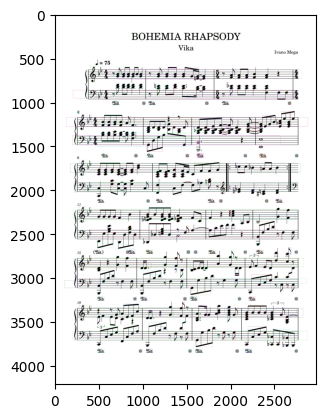

In [7]:
# img = cv2.imread("ds2_dense/images/lg-900267602436792595-aug-gutenberg1939--page-4.png", cv2.IMREAD_GRAYSCALE)
img = cv2.imread("sheets/bohemia rhapsody.png", cv2.IMREAD_GRAYSCALE)

res = detector(img)

boxes = []
labels = []

for label in res:
    boxes.append(label.box if torch.is_tensor(label.box) else torch.stack(label.box))
    labels.append(label.name)

plt.imshow(draw_bounding_boxes(torch.tensor(img).unsqueeze(0), torch.stack(boxes), labels).moveaxis(0, 2))
plt.savefig("img2.png", dpi=800)


In [8]:
from dataset import MusicSheetDataSet

max_asp = 0
min_asp = 100

def trans(image, target):
    global max_asp, min_asp

    y, x = image.shape

    asp = y / x
    if asp > max_asp:
        max_asp = asp
    if asp < min_asp:
        min_asp = asp


x = MusicSheetDataSet("ds2_dense", "train", trans)

for i in x:
    pass

print(max_asp, min_asp)

# image, target = dataset[0]
# print(image.shape)
# _, x, y = image.shape


# scaleX = 800 / x
# scaleY = 800 / y

# # image = cv2.resize(image.mul(255).type(torch.uint8).numpy(), dsize=(800, 800))

# # target = model(image.unsqueeze(0).to(device))[0]

# plt.imshow(draw_bounding_boxes(
#     image.mul(255).type(torch.uint8), 
#     torch.concat([torch.tensor([b[0] * scaleX, b[1] * scaleY, b[2] * scaleX, b[3] * scaleY]).unsqueeze(0) for b in target['boxes']]), 
#     [oneset_rev[x.item()] for x in target['labels']]
# ).moveaxis(0, 2))
# plt.savefig("img.png", dpi=800)





1.4148148148148147 1.4138398914518318
